In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.models import Sequential
from keras.layers import Dense,  LSTM,  Dropout, SimpleRNN, Input, GRU
from keras.models import Model
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from plot_keras_history import plot_history
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.
C:\home\anaconda\envs\TF\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
os.chdir('../')
path = os.getcwd()
print(path)

C:\home\program


In [3]:
tokyo = pd.read_csv('Stock2/東京(2014-1_2020-11).csv')
data =pd.read_csv("FX/円ドル(2014-1_2020-11).csv")

tokyo['日付'] = pd.to_datetime(tokyo['日付'], format='%Y/%m/%d')

In [4]:
tokyo = tokyo.drop_duplicates(['日付', '終値'])
data = data.drop_duplicates(['日付', '終値'])

In [5]:
tokyo.set_index('日付')
dateTimeIndex = pd.DatetimeIndex(tokyo['日付'])
tokyo.index = dateTimeIndex
tokyo = tokyo.resample('D').interpolate()
tokyo.drop("日付", axis=1)

,終値
日付,
2014-01-06,686.000000
2014-01-07,677.000000
2014-01-08,692.000000
2014-01-09,681.000000
2014-01-10,686.000000
...,...
2020-11-12,451.000000
2020-11-13,445.600000
2020-11-14,450.766667


In [6]:
dateTimeIndex = pd.DatetimeIndex(data['日付'])
data.index = dateTimeIndex
data = data.drop('日付', axis=1)

In [7]:
tokyo = tokyo.astype({'終値': int})
F_tokyo = data.astype({'終値': int})

In [8]:
Tokyo = pd.DataFrame(tokyo['終値']['2015-01-01':'2020-10-31'])
F_Tokyo = pd.DataFrame(F_tokyo['終値']['2015-01-01':'2020-10-31'])

In [9]:
Tokyo['FX'] = F_tokyo['終値']

In [10]:
len(Tokyo)

2131

In [11]:
scale = pd.DataFrame(np.nan_to_num(np.log(Tokyo['終値'].values + 1)))
scale.index = Tokyo.index.values

scale['second'] = np.nan_to_num(np.log(Tokyo['FX'].values + 1))
X_day_second = tokyo.index.values

In [12]:
X_orig = np.nan_to_num(np.log(Tokyo['終値'].values + 1))
X_day = Tokyo.index.values

X_orig_second = np.nan_to_num(np.log(Tokyo['FX'].values + 1))
X_day_second = Tokyo.index.values

In [13]:
half = round(len(X_orig)/2)

X_train = X_orig[:half-1]
X_test = X_orig[half:]
X_train_day = X_day[:half-1]
X_test_day = X_day[half:]

X_train_second = X_orig_second[:half-1]
X_test_second = X_orig_second[half:]
X_train_day_second = X_day_second[:half-1]
X_test_day_second = X_day_second[half:]

In [14]:
def show_graph(day, data, label, color="b", ylabel='stock price'):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel(ylabel)
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()

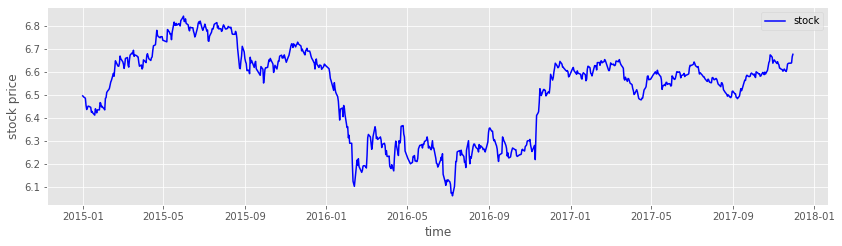

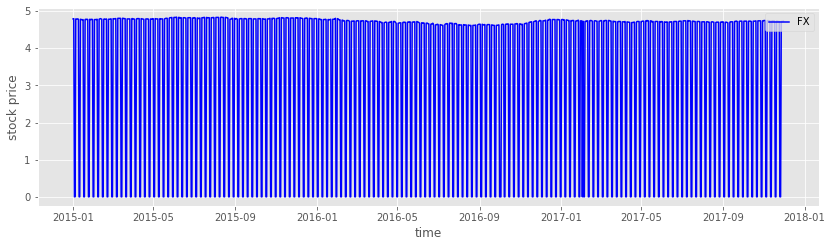

In [15]:
import pylab
plt.style.use('ggplot')
show_graph(X_train_day, X_train, 'stock')
show_graph(X_train_day_second, X_train_second, 'FX')

In [16]:
X_train_joint = np.vstack((X_train, X_train_second))
X_test_joint = np.vstack((X_test, X_test_second))

X_train_joint.shape

(2, 1065)

In [17]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    dataX = np.zeros((data.shape[0], data.shape[1], time_steps))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - time_steps - 1):
            dataX[i][j] = data[i, j:(j + time_steps)].T
    return np.array(dataX)

In [18]:
def transform_data(original_data: np.array, 
                   inverse_option: bool, 
                   scaler: object,
                   variable_number: int,
                  ):
    data_shape = original_data.shape
    print(original_data.shape)
    data = original_data.reshape(-1, variable_number)
    print(data.shape)
    if inverse_option is True:
        print('before max {}'.format(max(data[0])))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data[0])))
    else:
        print('before max {}'.format(max(data[0])))
        print('Normalize')
        data = scaler.fit_transform(data)
        print('after max {}'.format(max(data[0])))
    data = data.reshape(data_shape)
    return data, scaler

In [19]:
def prepare_data(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x = np.swapaxes(x, 0, 1)
    x = np.swapaxes(x, 1, 2)
    return x, scaler

In [20]:
time_steps = 3
variable_number = 2

x, scaler = prepare_data(X_train_joint, time_steps, variable_number)

(2, 1065)
(1065, 2)
before max 6.495265555937008
Normalize
after max 0.9501198378368295
(2, 1065)


In [21]:
input_dim = x.shape[-1]
timesteps = x.shape[1]

In [22]:
def create_model(input_dim,time_steps,latent_dim,model_option,batch_size=1,optimizer='adam'):
    with tf.name_scope('Model'):
        x = Input(shape=(time_steps, input_dim,))

        if model_option == 'lstm':
            with tf.name_scope('LSTM'):
                h = LSTM(latent_dim, stateful=False, return_sequences=True)(x)
        elif model_option == 'gru':
            with tf.name_scope('GRU'):
                h = GRU(latent_dim, stateful=False, return_sequences=True)(x)

        print('input_dim:', input_dim)
        with tf.name_scope('Dense'):
            out = Dense(input_dim)(h)

        model = Model(x, out)
        model.summary()

        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

In [23]:
from copy import copy 

def predict_model_show_graph(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    with timer('predict'):
        preds = model.predict(prepare_value)
    
    print('prepare_value: ', prepare_value.shape)
    print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[-1]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[:, 0, i], color='r', label='data')
        plt.plot(preds[:, 0, i], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(preds, prepare_value))
    return preds, prepare_value
    # return predict_scale, x_scale

In [24]:
predict_list = []
var_list = []

print(x.shape)
model = create_model(input_dim,time_steps=time_steps,latent_dim=120,model_option='lstm')

(1065, 3, 2)
input_dim: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 2)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 120)            59040     
_________________________________________________________________
dense_1 (Dense)              (None, 3, 2)              242       
Total params: 59,282
Trainable params: 59,282
Non-trainable params: 0
_________________________________________________________________


In [25]:
import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.10f}s".format(title, time.time() - t0))

Epoch 1/300
1065/1065 [==============================] - 1s 621us/step - loss: 0.3188 - mse: 0.3188
Epoch 2/300
  32/1065 [..............................] - ETA: 0s - loss: 0.1604 - mse: 0.1604

C:\home\anaconda\envs\TF\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108103). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1065/1065 [==============================] - 0s 123us/step - loss: 0.1241 - mse: 0.1241
Epoch 3/300
1065/1065 [==============================] - 0s 130us/step - loss: 0.0641 - mse: 0.0641
Epoch 4/300
1065/1065 [==============================] - 0s 134us/step - loss: 0.0319 - mse: 0.0319
Epoch 5/300
1065/1065 [==============================] - 0s 132us/step - loss: 0.0155 - mse: 0.0155
Epoch 6/300
1065/1065 [==============================] - 0s 133us/step - loss: 0.0066 - mse: 0.0066
Epoch 7/300
1065/1065 [==============================] - 0s 132us/step - loss: 0.0031 - mse: 0.0031
Epoch 8/300
1065/1065 [==============================] - 0s 163us/step - loss: 0.0021 - mse: 0.0021
Epoch 9/300
1065/1065 [==============================] - 0s 132us/step - loss: 0.0017 - mse: 0.0017
Epoch 10/300
1065/1065 [==============================] - 0s 131us/step - loss: 0.0014 - mse: 0.0014
Epoch 11/300
1065/1065 [==============================] - 0s 122us/step - loss: 0.0012 - mse: 0.0012
Epoch 12/3

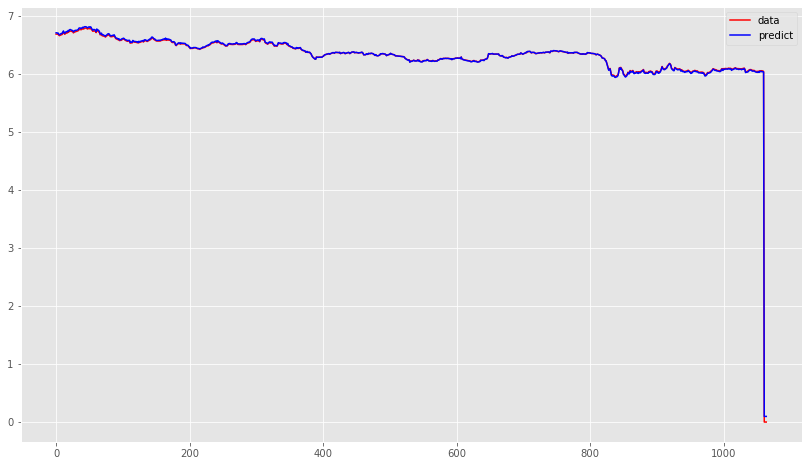

x_scale:  (1065, 3, 2)


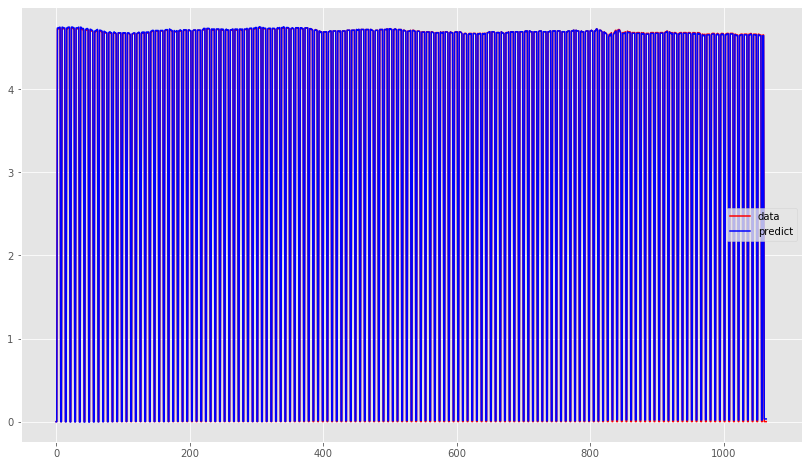

1065/1065 [==============================] - 0s 103us/step
model evaluate mse: [0.7426688444166676, 0.7426687479019165]


In [26]:
from pathlib import Path
from keras.callbacks import TensorBoard

log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,write_graph=True,embeddings_freq=0,)

with timer('train model simple'):
    model.fit(x, x, epochs=300, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], x_test, scaler, model,variable_number)

In [27]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.02779587235207164
rmse: 0.018151063497551658
0.02297346792481165


In [28]:
lstm_test = np.exp(x_scale_test[:, 0, 0])
lstm_pred = np.exp(predict_test[:, 0, 0])

In [29]:
F_lstm_predict = pd.DataFrame(lstm_pred)
F_lstm_predict.index = X_day_second[half:]

F_lstm_test = pd.DataFrame(lstm_test)
F_lstm_test.index = X_day[half:]

# GRU

In [30]:
model = create_model(input_dim,time_steps=time_steps,latent_dim=120,model_option='gru')

input_dim: 2
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 2)              0         
_________________________________________________________________
gru_1 (GRU)                  (None, 3, 120)            44280     
_________________________________________________________________
dense_2 (Dense)              (None, 3, 2)              242       
Total params: 44,522
Trainable params: 44,522
Non-trainable params: 0
_________________________________________________________________


Epoch 1/300
1065/1065 [==============================] - 1s 701us/step - loss: 0.2356 - mse: 0.2356


C:\home\anaconda\envs\TF\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.126512). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


Epoch 2/300
1065/1065 [==============================] - 0s 142us/step - loss: 0.0649 - mse: 0.0649
Epoch 3/300
1065/1065 [==============================] - 0s 145us/step - loss: 0.0263 - mse: 0.0263
Epoch 4/300
1065/1065 [==============================] - 0s 143us/step - loss: 0.0106 - mse: 0.0106
Epoch 5/300
1065/1065 [==============================] - 0s 143us/step - loss: 0.0040 - mse: 0.0040
Epoch 6/300
1065/1065 [==============================] - 0s 144us/step - loss: 0.0017 - mse: 0.0017
Epoch 7/300
1065/1065 [==============================] - 0s 145us/step - loss: 0.0010 - mse: 0.0010
Epoch 8/300
1065/1065 [==============================] - 0s 173us/step - loss: 8.2980e-04 - mse: 8.2980e-04
Epoch 9/300
1065/1065 [==============================] - 0s 141us/step - loss: 7.1844e-04 - mse: 7.1844e-04
Epoch 10/300
1065/1065 [==============================] - 0s 140us/step - loss: 6.3557e-04 - mse: 6.3557e-04
Epoch 11/300
1065/1065 [==============================] - 0s 143us/step - l

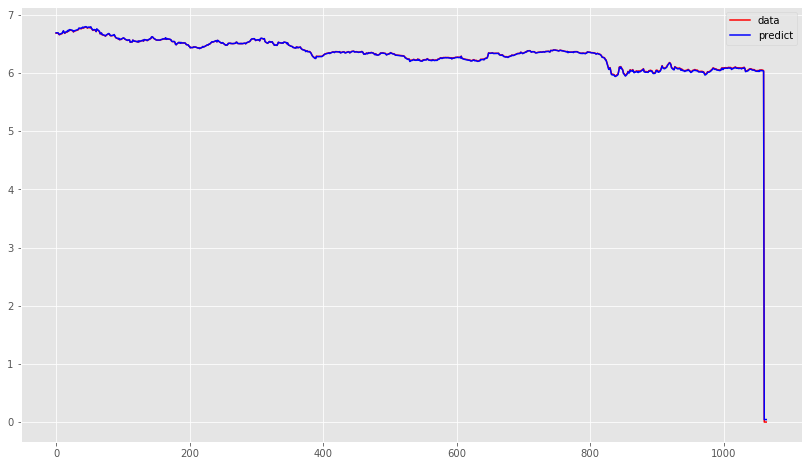

x_scale:  (1065, 3, 2)


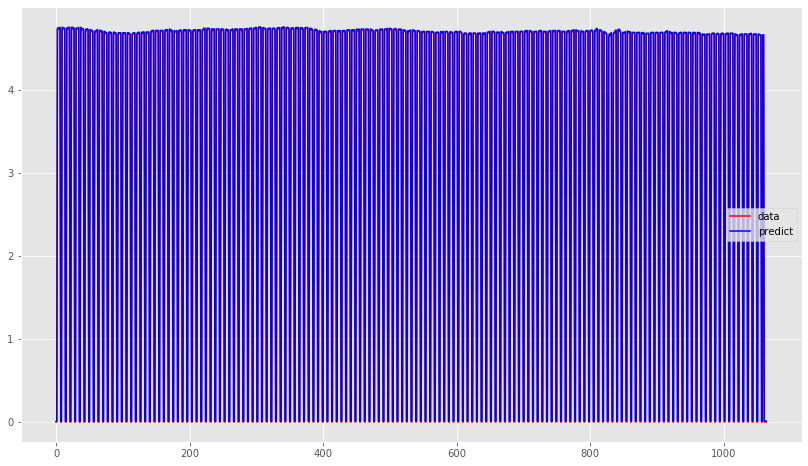

1065/1065 [==============================] - 0s 103us/step
model evaluate mse: [0.31946213245391847, 0.3194621205329895]


In [31]:
log_dir = 'simple_multi_model'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,write_graph=True,embeddings_freq=0,)

with timer('train model simple'):
    model.fit(x, x, epochs=300, callbacks=[tensorboard])
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], x_test, scaler, model,variable_number)

In [32]:
rmse_list = []
for i in range(predict_test.shape[-1]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[:, :, i], predict_test[:, :, i]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.004297206970141162
rmse: 0.020082287756024445
0.012189747363082804


In [33]:
gru_test = np.exp(x_scale_test[:, 0, 0])
gru_pred = np.exp(predict_test[:, 0, 0])

In [34]:
F_gru_predict = pd.DataFrame(gru_pred)
F_gru_predict.index = X_day_second[half:]

F_gru_test = pd.DataFrame(gru_test)
F_gru_test.index = X_day[half:]

# plot

In [37]:
F_lstm_test = F_lstm_test.drop(F_lstm_test.index[[len(F_lstm_test)-1,len(F_lstm_test)-2, len(F_lstm_test)-3, len(F_lstm_test)-4]])
F_lstm_predict = F_lstm_predict.drop(F_lstm_predict.index[[len(F_lstm_predict)-1,len(F_lstm_predict)-2, len(F_lstm_predict)-3, len(F_lstm_predict)-4]])
F_gru_test = F_gru_test.drop(F_gru_test.index[[len(F_gru_test)-1,len(F_gru_test)-2, len(F_gru_test)-3, len(F_gru_test)-4]])
F_gru_predict = F_gru_predict.drop(F_gru_predict.index[[len(F_gru_predict)-1,len(F_gru_predict)-2, len(F_gru_predict)-3, len(F_gru_predict)-4]])

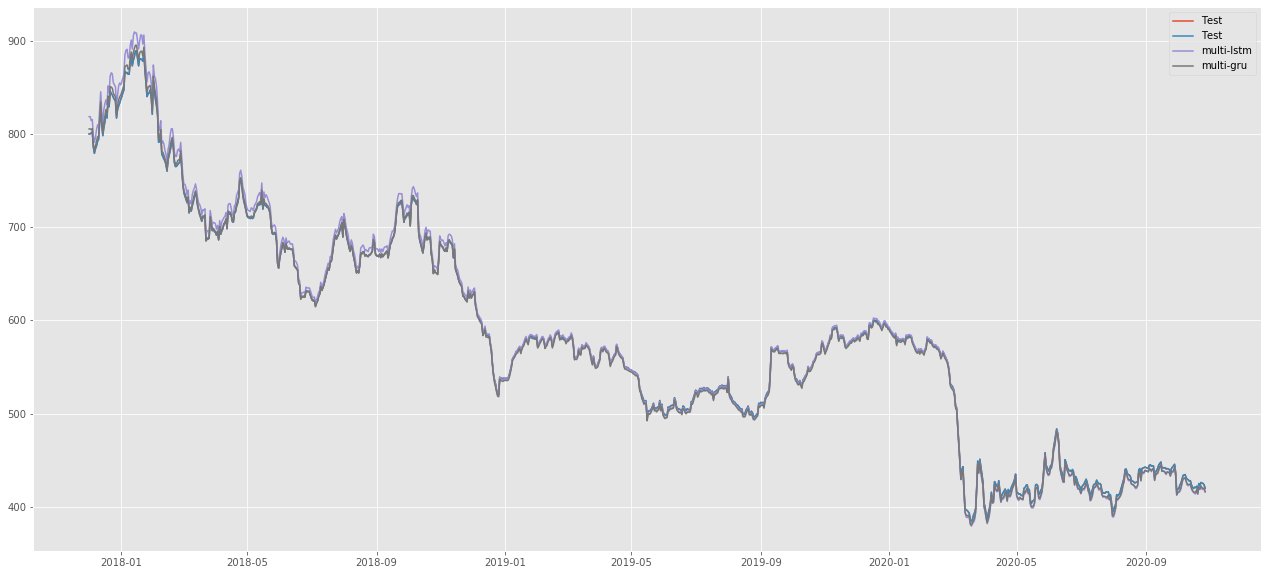

In [38]:
plt.figure(figsize=(22,10))
plt.plot(F_lstm_test, label = 'Test')
plt.plot(F_gru_test, label = 'Test')
plt.plot(F_lstm_predict, label = 'multi-lstm')
plt.plot(F_gru_predict, label = 'multi-gru')
plt.legend(loc='best')
#plt.savefig('画像/11-23/FX-epoch300.png')

# lstm

# normal

# RMSE

In [ ]:
rmse = np.sqrt(np.average(np.subtract(F_lstm_test, F_lstm_predict) ** 2))
print('rmse:', rmse)

In [ ]:
rmse = np.sqrt(np.average(np.subtract(F_gru_test, F_gru_predict) ** 2))
print('rmse:', rmse)